In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from assemble_catalog import assemble_catalog as assemble_history_data

snapshot_root_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/binary_reductions/z0/binaries/"
num_subvols = 144
history_cols = ('halo_id', 'halo_upid', 'halo_mpeak', 'halo_vmax_at_mpeak', 
                'stellar_mass', 'sfr', 'sfr_mp', 'sm_mp')
histories = Table(assemble_history_data(snapshot_root_dirname, num_subvols, *history_cols))

In [4]:
from quenching_time import quenching_time
histories['quenching_time'] = quenching_time(histories['sfr_mp'], histories['sm_mp'])

In [5]:
from halocat_binary_reduction import assemble_halocat, read_column_info_array

halocat_binary_dirname = "/Users/aphearin/Dropbox/UniverseMachine/data/halocat_snapshot/a_1.00231"
column_info_fname = os.path.join(os.path.dirname(halocat_binary_dirname), 'column_info.dat')
column_info_array = read_column_info_array(column_info_fname)
propnames = ('halo_id', 'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 'delta_vmax_tdyn_behroozi16', 
            'x', 'y', 'z', 'vx', 'vy', 'vz')
halo_table = Table(assemble_halocat(halocat_binary_dirname, column_info_array, *propnames))
print("Available columns = \n{0}\n".format(halo_table.keys()))
print("number of halos in snapshot = {0}".format(len(halo_table)))

Available columns = 
['halo_id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'mpeak', 'acc_rate_1tdyn', 'mpeak_scale', 'first_acc_scale', 'delta_vmax_tdyn_behroozi16']

number of halos in snapshot = 12085858


In [6]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(histories['halo_id'].data, halo_table['halo_id'].data)
histories = histories[idxA]

keys_to_add = ('x', 'y', 'z', 'vx', 'vy', 'vz', 
               'first_acc_scale', 'acc_rate_1tdyn', 'mpeak_scale', 
               'delta_vmax_tdyn_behroozi16', 'mpeak')
for key in keys_to_add:
    histories[key] = halo_table[key][idxB]

In [25]:
histories['time_first_acc'] = np.interp(histories['first_acc_scale'], scale_factor_array, cosmic_age_array)
histories['host_mpeak'] = histories['halo_mpeak']

In [34]:
from history_functions import ssfr_at_infall

histories['ssfr_at_infall'] = ssfr_at_infall(histories['sfr_mp'].data, 
                                histories['sm_mp'].data, histories['time_first_acc'].data)

satmask = histories['halo_upid'] != -1
sats = histories[satmask]

In [35]:
idxA, idxB = crossmatch(sats['halo_upid'], histories['halo_id'])
sats['host_mpeak'][idxA] = histories['halo_mpeak'][idxB]
histories['host_mpeak'][satmask] = sats['host_mpeak']

In [36]:
quenched_satmask = np.log10(sats['sfr']/sats['stellar_mass']) < -11
quenched_sats = sats[quenched_satmask]

# Plot fraction that quenched after infall

In [59]:
logsm_low, logsm_high, num_sm_bins = 9.5, 11.5, 15
sm_bins = np.logspace(logsm_low, logsm_high, num_sm_bins)
sm_mids = 10**((np.log10(sm_bins)[1:] + np.log10(sm_bins)[:-1])/2.)

host_mass_bins = [10**12, 10**13, 10**14, np.inf]

frac_quenched_as_sat = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_milky_way = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_group = np.zeros(len(sm_bins)-1)
frac_quenched_as_sat_cluster = np.zeros(len(sm_bins)-1)

for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    sm_bin_active_at_infall_mask = sm_bin_mask * (quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat[i] = len(quenched_sats[sm_bin_active_at_infall_mask])/float(len(quenched_sats[sm_bin_mask]))
    
    milky_way_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[0])*(quenched_sats['host_mpeak'] < host_mass_bins[1])
    milky_way_sm_bin_active_at_infall_mask = milky_way_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_milky_way[i] = len(quenched_sats[milky_way_sm_bin_active_at_infall_mask])/float(len(quenched_sats[milky_way_sm_bin_mask]))

    group_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[1])*(quenched_sats['host_mpeak'] < host_mass_bins[2])
    group_sm_bin_active_at_infall_mask = group_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_group[i] = len(quenched_sats[group_sm_bin_active_at_infall_mask])/float(len(quenched_sats[group_sm_bin_mask]))

    cluster_sm_bin_mask = sm_bin_mask*(quenched_sats['host_mpeak'] > host_mass_bins[2])*(quenched_sats['host_mpeak'] < host_mass_bins[3])
    cluster_sm_bin_active_at_infall_mask = cluster_sm_bin_mask*(quenched_sats['ssfr_at_infall'] > -11)
    frac_quenched_as_sat_cluster[i] = len(quenched_sats[cluster_sm_bin_active_at_infall_mask])/float(len(quenched_sats[cluster_sm_bin_mask]))


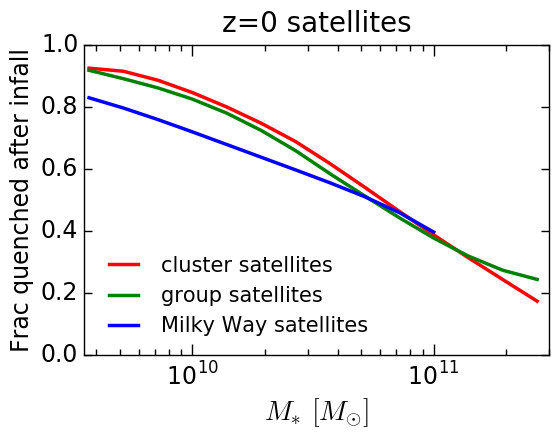

In [80]:
from scipy.signal import savgol_filter

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel('Frac quenched after infall', fontsize=17)
title = ax.set_title('z=0 satellites', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_cluster, 13, 5), color='red', 
        linewidth=2.5, label = "cluster satellites")

ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat_group, 13, 4), color='green', 
        linewidth=2.5, label = "group satellites")

# ax.plot(sm_mids, savgol_filter(frac_quenched_as_sat, 13, 4), color='k', 
#         linewidth=2.5, label = "all satellites")

ax.plot(sm_mids[:-3], savgol_filter(frac_quenched_as_sat_milky_way[:-3], 11, 5), color='blue', 
        linewidth=2.5, label = "Milky Way satellites")

plt.tick_params(axis='x', length=8, width=1, which='major') 
plt.tick_params(axis='x', length=4, width=1, which='minor') 
plt.tick_params(axis='y', length=6, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin = 10**9.55, xmax=3*10**11)
plt.ylim(ymin = 0, ymax = 1)
plt.legend(frameon=False, loc='lower left', fontsize=15)

fig.savefig('FIGS/post_infall_quenching_fractions.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Plot the quenching time

In [74]:
from quenching_time import quenching_time
quenched_sats['quenching_time'] = quenching_time(quenched_sats['sfr_mp'], quenched_sats['sm_mp'])

In [75]:
quenched_sats['quenching_time_delay'] = quenched_sats['quenching_time'] - quenched_sats['time_first_acc'] 

In [77]:
log_mhost_bins = np.array((12, 13, 14, np.inf))
mhost_bins = 10**log_mhost_bins

In [78]:
quenching_time_delay = np.zeros((len(sm_bins)-1, 4))
for i, sm_low, sm_high in zip(range(len(sm_bins)-1), sm_bins[0:-1], sm_bins[1:]):
    sm_bin_mask = (quenched_sats['stellar_mass'] > sm_low) & (quenched_sats['stellar_mass'] < sm_high)
    quenching_time_delay[i, 0] = np.mean(quenched_sats[sm_bin_mask]['quenching_time_delay'])
    
    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[0])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[1])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 1] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])

    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[1])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[2])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 2] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])

    mhost_mask = sm_bin_mask * (quenched_sats['host_mpeak'] >= mhost_bins[2])
    mhost_mask *= (quenched_sats['host_mpeak'] < mhost_bins[3])
    if len(quenched_sats[mhost_mask]) > 0:
        quenching_time_delay[i, 3] = np.mean(quenched_sats[mhost_mask]['quenching_time_delay'])


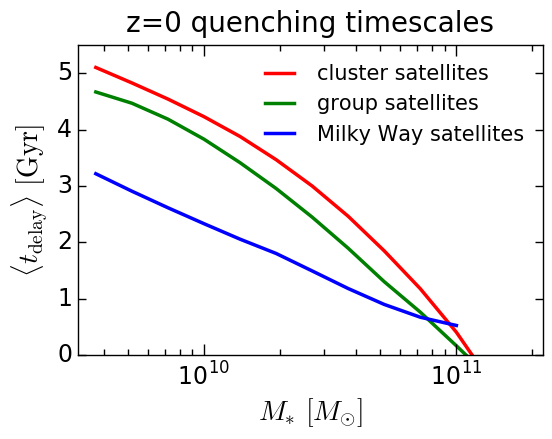

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M_{\ast}$ $[M_{\odot}]$', fontsize=20)
ylabel = ax.set_ylabel(r'$\langle t_{\rm delay} \rangle$ $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title('z=0 quenching timescales', fontsize=20, y=1.02) # y param fixes an overhanging title

ax.plot(sm_mids, savgol_filter(quenching_time_delay[:, 3], 9, 3), color='red', 
        linewidth=2.5, label = "cluster satellites")
ax.plot(sm_mids, savgol_filter(quenching_time_delay[:, 2], 9, 3), color='green', 
        linewidth=2.5, label = "group satellites")
ax.plot(sm_mids[:-3], savgol_filter(quenching_time_delay[:, 1][:-3], 9, 3), color='blue', 
        linewidth=2.5, label = "Milky Way satellites")


plt.tick_params(axis='x', length=8, width=1, which='major') 
plt.tick_params(axis='x', length=4, width=1, which='minor') 
plt.tick_params(axis='y', length=6, width=1, which='major') 
plt.xscale('log')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(xmin = 10**9.5, xmax=2.2*10**11)
plt.ylim(ymin = 0, ymax = 5.5)
plt.legend(frameon=False, loc='upper right', fontsize=15)

fig.savefig('FIGS/quenching_timescales.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

# Compare infall time distributions 

### Compare infall time distributions: Mhost-dependence

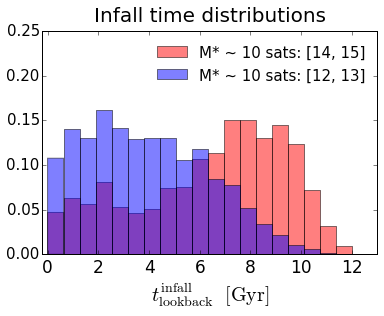

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (sats['sm'] > 10**sm_low) & (sats['sm'] < 10**sm_high)

mhost_mask = sm_mask * (sats['mvir_host_halo'] > 10**14) & (sats['mvir_host_halo'] < 10**15)
__=plt.hist(cosmic_age_array[-1] - sats['time_first_acc'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "M* ~ 10 sats: [14, 15]", color='red')

mhost_mask = sm_mask * (sats['mvir_host_halo'] > 10**12) & (sats['mvir_host_halo'] < 10**13)
__=plt.hist(cosmic_age_array[-1] - sats['time_first_acc'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "M* ~ 10 sats: [12, 13]", color='blue')

sm_mask = (sats['sm'] > 10**sm_low) & (sats['sm'] < 10**sm_high)

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm infall}$  $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title('Infall time distributions', fontsize=20, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=17)
plt.yticks(fontsize=15)
plt.xlim(xmin = -0.2, xmax=13)
plt.ylim(ymin = 0, ymax = 0.25)
plt.legend(frameon=False, loc='upper right', fontsize=15)
fig.savefig('FIGS/infall_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

### Compare infall time distributions: difference between quenched and star-forming sats

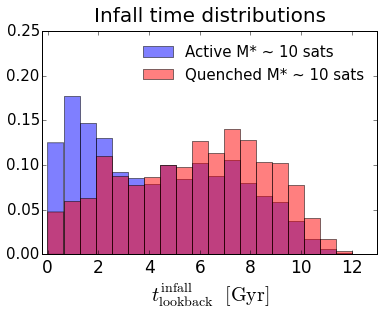

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (sats['sm'] > 10**sm_low) & (sats['sm'] < 10**sm_high)
quenched_mask = sm_mask * (sats['sfr'] / sats['sm'] < 1e-11)
active_mask = sm_mask * (sats['sfr'] / sats['sm'] > 1e-11)

__=plt.hist(cosmic_age_array[-1] - sats['time_first_acc'][active_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = 'Active M* ~ 10 sats', color='blue')

__=plt.hist(cosmic_age_array[-1] - sats['time_first_acc'][quenched_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats", color='red')

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm infall}$  $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title('Infall time distributions', fontsize=20, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=17)
plt.yticks(fontsize=15)
plt.xlim(xmin = -0.2, xmax=13)
plt.ylim(ymin = 0, ymax = 0.25)
plt.legend(frameon=False, loc='upper right', fontsize=15)
fig.savefig('FIGS/infall_time_distributions_sfr_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

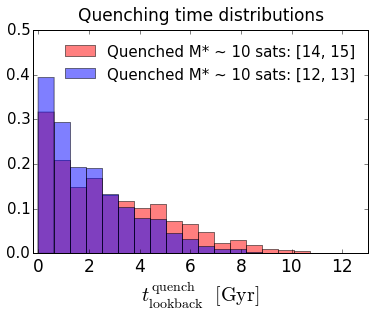

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['sm'] > 10**sm_low) & (quenched_sats['sm'] < 10**sm_high)

mhost_mask = sm_mask * (quenched_sats['mvir_host_halo'] > 10**14) & (quenched_sats['mvir_host_halo'] < 10**15)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats: [14, 15]", color='red')

mhost_mask = sm_mask * (quenched_sats['mvir_host_halo'] > 10**12) & (quenched_sats['mvir_host_halo'] < 10**13)
__=plt.hist(cosmic_age_array[-1] - quenched_sats['quenching_time'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats: [12, 13]", color='blue')

xlabel = ax.set_xlabel(r'$t_{\rm lookback}^{\rm quench}$  $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title('Quenching time distributions', fontsize=17, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=17)
plt.yticks(fontsize=15)
plt.xlim(xmin = -0.2, xmax=13)
plt.ylim(ymin = 0, ymax = 0.5)
plt.legend(frameon=False, loc='upper right', fontsize=15)
fig.savefig('FIGS/quenching_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

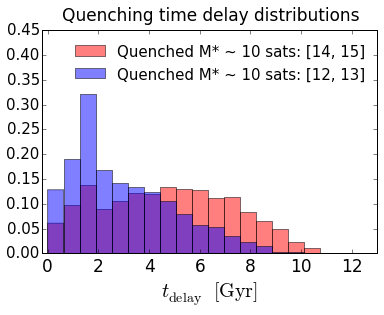

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

sm_low, sm_high = 10, 10.25

sm_mask = (quenched_sats['sm'] > 10**sm_low) & (quenched_sats['sm'] < 10**sm_high)

mhost_mask = sm_mask * (quenched_sats['mvir_host_halo'] > 10**14) & (quenched_sats['mvir_host_halo'] < 10**15)
__=plt.hist(quenched_sats['quenching_time'][mhost_mask] - quenched_sats['time_first_acc'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats: [14, 15]", color='red')

mhost_mask = sm_mask * (quenched_sats['mvir_host_halo'] > 10**12) & (quenched_sats['mvir_host_halo'] < 10**13)
__=plt.hist(quenched_sats['quenching_time'][mhost_mask] - quenched_sats['time_first_acc'][mhost_mask], 
            bins=np.linspace(0, 12, 20), normed=True, alpha=0.5, 
            label = "Quenched M* ~ 10 sats: [12, 13]", color='blue')

xlabel = ax.set_xlabel(r'$t_{\rm delay}$  $[{\rm Gyr}]$', fontsize=20)
title = ax.set_title('Quenching time delay distributions', fontsize=17, y=1.02) # y param fixes an overhanging title

plt.xticks(fontsize=17)
plt.yticks(fontsize=15)
plt.xlim(xmin = -0.2, xmax=13)
plt.ylim(ymin = 0, ymax = 0.45)
plt.legend(frameon=False, loc='upper right', fontsize=15)
fig.savefig('FIGS/delay_time_distributions_host_dependence.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')